## Initial Classification
(Jupyter Notebook 2 of 3)

#### -------- Section 3: Optimize fitting parameters of several models with cross-validation  --------------------------------
Trying few enough models that repeating code for each model is fine. In future, batch processing by collecting
parameters into variables would be better.

Result: Random Forest and KNN classifiers are comparable.

In [1]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import make_scorer
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.utils import class_weight

import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
# Load in the data saved previously in the "Data Loading" notebook #
# Elements are [X_trainraw, y_trainraw, X_testraw, y_testraw, terrain_labels].
import pickle

with open('data/dataframes_raw_20181023.pkl', 'rb') as picklefile: 
    raw_data = pickle.load(picklefile)

X_trainraw = raw_data[0]; y_trainraw = raw_data[1]
X_testraw = raw_data[2]; y_testraw = raw_data[3]
terrain_labels = raw_data[4]

In [3]:
# Pre-compute stratified folds for the cross-validation below #
ksplits = StratifiedKFold(n_splits=10, random_state=42)

In [4]:
# Import utility functions for scoring and displaying data #
import ClassAnalysis
import importlib
importlib.reload(ClassAnalysis)
from ClassAnalysis import plot_confusion_matrix, report_scores, accuracy_weighted

# Set up accuracy scoring to account for imbalance of class distribution #
nclasses = y_trainraw.nunique()
weights = class_weight.compute_class_weight('balanced', list(range(1,nclasses+1)), y_trainraw)

scorer = make_scorer(accuracy_weighted, class_weights=weights)

__(1) K-nearest Neighbors__  
Best parameters are weighting = UNIFORM and # neighbors = 4. Weighted accuracy = 0.827.

In [5]:
# Set up KNN model #
model = KNeighborsClassifier()
grid_values = {'n_neighbors': [1] + list(range(2, 21, 2)), 'weights': ['uniform','distance']}

In [6]:
# Run the model and print results #
grid_knn = GridSearchCV(model, cv=ksplits, param_grid=grid_values, scoring=scorer, n_jobs=-1)
grid_knn.fit(X_trainraw, y_trainraw);

print(grid_knn.best_estimator_)
print(grid_knn.best_params_)
print(grid_knn.best_score_)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=4, p=2,
           weights='uniform')
{'n_neighbors': 4, 'weights': 'uniform'}
0.827433599583


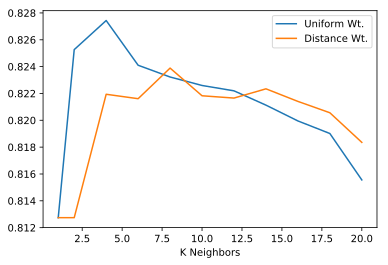

In [7]:
# Plot the results of the CV search #
cv_test_scores = grid_knn.cv_results_['mean_test_score']
cv_params = grid_knn.cv_results_['params']

xx_uniform, yy_uniform = [], []
xx_distance, yy_distance = [], []
for p,x in zip(cv_params,cv_test_scores):
    if p['weights']=='uniform':
        xx_uniform.append(p['n_neighbors'])
        yy_uniform.append(x)
    else:
        xx_distance.append(p['n_neighbors'])
        yy_distance.append(x)

plt.plot(xx_uniform,yy_uniform);
plt.plot(xx_distance,yy_distance);
plt.xlabel('K Neighbors')
plt.legend(['Uniform Wt.', 'Distance Wt.']);

__(2) Logistic Regression__  
Best parameters for rdm=42 for penalty = L2 is C = 0.1 (really >.001). Weighted accuracy = 0.744.

In [8]:
# Set up logistic regression model #
model = LogisticRegression(random_state=42, solver='newton-cg')
grid_values = {'penalty': ['l2'],'C': np.logspace(-4, 1, 6),
        'multi_class': ['ovr']}

In [9]:
# Run the model and print results (identical to above) #
grid_lr = GridSearchCV(model, cv=ksplits, param_grid=grid_values, scoring=scorer, n_jobs=-1)
grid_lr.fit(X_trainraw, y_trainraw);

print(grid_lr.best_estimator_)
print(grid_lr.best_params_)
print(grid_lr.best_score_)

/Users/neuromac/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/neuromac/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/neuromac/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


LogisticRegression(C=0.10000000000000001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=42,
          solver='newton-cg', tol=0.0001, verbose=0, warm_start=False)
{'C': 0.10000000000000001, 'multi_class': 'ovr', 'penalty': 'l2'}
0.744836233691


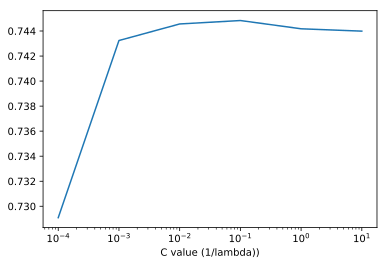

In [10]:
# Plot the results of the CV search #
cv_test_scores = grid_lr.cv_results_['mean_test_score']
cv_params = grid_lr.cv_results_['params']

xx_l2, yy_l2 = [], []
# xx_l1, yy_l1 = [], []
for p,y in zip(cv_params,cv_test_scores):
    if p['penalty']=='l2':
        xx_l2.append(p['C'])
        yy_l2.append(y)
    else:
        xx_l1.append(p['C'])
        yy_l1.append(y)

plt.semilogx(xx_l2,yy_l2);
plt.xlabel('C value (1/lambda))');
# plt.semilogx(xx_l1,yy_l1);

__(2) Random Forest__  
Best parameters for rdm=42 are n_estimators = 100 and max_features = 30%. Weighted accuracy = 0.840.

In [11]:
# Set up random forest model #
model = RandomForestClassifier(random_state=42)
grid_values = {'n_estimators': np.array([25,50,100]),'max_features': np.linspace(0.1,0.5,5)}

In [12]:
# Run the model and print results (identical to above) #
grid_rf = GridSearchCV(model, cv=ksplits, param_grid=grid_values, scoring=scorer, n_jobs=-1)
grid_rf.fit(X_trainraw, y_trainraw);

print(grid_rf.best_estimator_)
print(grid_rf.best_params_)
print(grid_rf.best_score_)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=0.30000000000000004,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)
{'max_features': 0.30000000000000004, 'n_estimators': 100}
0.84039545858


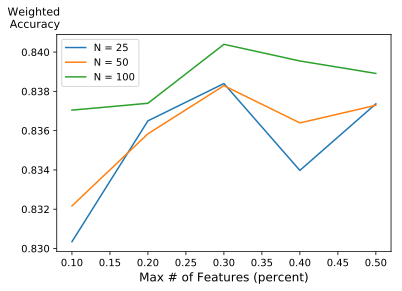

In [28]:
# Plot the results of the CV search #
cv_test_scores = grid_rf.cv_results_['mean_test_score']
cv_params = grid_rf.cv_results_['params']

xx_sm, yy_sm = [], []
xx_md, yy_md = [], []
xx_lg, yy_lg = [], []
for p,y in zip(cv_params,cv_test_scores):
    if p['n_estimators']==25:
        xx_sm.append(p['max_features'])
        yy_sm.append(y)
    elif p['n_estimators']==50:
        xx_md.append(p['max_features'])
        yy_md.append(y)
    elif p['n_estimators']==100:
        xx_lg.append(p['max_features'])
        yy_lg.append(y)

plt.plot(xx_sm,yy_sm);
plt.plot(xx_md,yy_md);
plt.plot(xx_lg,yy_lg);
plt.xlabel('Max # of Features (percent)', fontsize=12);
plt.ylabel('Weighted\nAccuracy', fontsize=11, rotation=0, ha='right');
plt.gca().yaxis.set_label_coords(0.01,1.02)
plt.legend(['N = 25','N = 50','N = 100']);

fig = plt.gcf()
fig.savefig('supporting_files/RF_Parameters.svg', dpi=300)

#### -------- Section 4: Defining the best model (for non-transformed training data) -------------------------
Moving forward with Random Forest classifier.

In [14]:
# Refit the Random Forest model to the best parameters, now using all of the training data #
model = RandomForestClassifier(n_estimators=100, max_features = .30, random_state=42)
model.fit(X_trainraw, y_trainraw)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=0.3, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

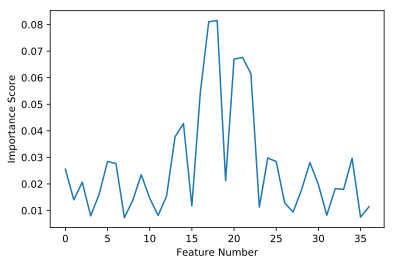

In [30]:
# Mainly out of curiousity, plot the importance of the features #
# Note there are concerns about '.feature_importances' being biased; however, in this case
#   all the features are continuous and have comparable scales which should be OK.
# As might be expected, the most important features, according to this function, are close to
#   the range 17-20, which correspond to the center of the 3x3 grid. Interestingly, the higher-
#   wavelength IR component, across all grid points, seems to be the least important, which imparts
#   a jagged appearance to the function (as any one spectral component is represented every 4 features).
plt.plot(np.linspace(0,36,37), model.feature_importances_);
plt.xlabel('Feature Number'); plt.ylabel('Importance Score');

                precision    recall  f1-score   support

      red soil       1.00      1.00      1.00 739.1666666666731
   cotton crop       1.00      1.00      1.00 739.1666666666696
     grey soil       1.00      1.00      1.00 739.1666666666827
     damp soil       1.00      1.00      1.00 739.1666666666715
    vegetation       1.00      1.00      1.00 739.1666666666705
very damp soil       1.00      1.00      1.00 739.1666666666766

   avg / total       1.00      1.00      1.00 4435.000000000045



-- Metric ----- Weighted Average ----
 Accuracy:       1.000
 Precision:      1.000
 Recall:         1.000
 F1 Score:       1.000




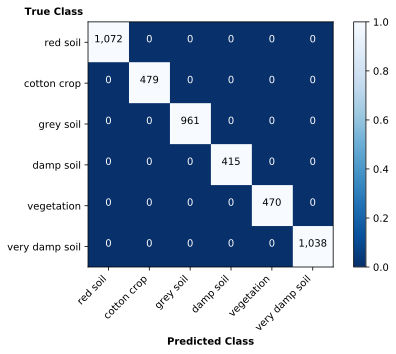

In [16]:
# Report the full statistics for the Random Forest fit #
# The result is PERFECT CLASSIFICATION! (This doesn't happen with the KNN and Log.Reg. models.)
# Note that 'report_scores()' below is a custom made utility function.
ypred_trainraw = model.predict(X_trainraw);
cm_plt = report_scores(y_trainraw, ypred_trainraw, terrain_labels, 'balanced', 'Weighted Average');
cm_plt.savefig('supporting_files/CMat_Train.svg')